# ML Data Analysis


Create `DataFrame`s from processed datasets.

In [1]:
%load_ext autoreload
%autoreload 2
from data.load import load_parquet

tempanomalies_df = load_parquet('tempanomalies')
land_cover_df = load_parquet('land_cover_types')
co2_df = load_parquet('co2')

print(tempanomalies_df.columns)
print(land_cover_df.columns)
print(co2_df.columns)

Index(['time', 'lat', 'lon', 'tempanomaly'], dtype='object')
Index(['time', 'band', 'lat', 'lon', 'land_cover_type', 'spatial_ref',
       'land_cover_type_name', 'geometry'],
      dtype='object')
Index(['sounding_id', 'xco2', 'time', 'lat', 'lon'], dtype='object')


Extract necessary features for tempanomalies prediction.

In [3]:
from datetime import timedelta
import numpy as np

t_df = tempanomalies_df.dropna(inplace=False).copy()

prediction_time = max(list(map(lambda t: t.to_pydatetime(), t_df["time"]))) + timedelta(
    days=30
)

t_df["month"] = list(map(lambda t: t.to_pydatetime().month, t_df["time"]))
t_df["season"] = list(map(lambda t: ((t % 12) // 3) + 1, t_df["month"]))
t_df["year"] = list(map(lambda t: t.to_pydatetime().year, t_df["time"]))
t_df["month_sin"] = np.sin(2 * np.pi * t_df["month"] / 12)
t_df["month_cos"] = np.cos(2 * np.pi * t_df["month"] / 12)
t_df["time"] = list(map(lambda t: t.timestamp(), t_df["time"]))


Train Gradient Boosting regression to predict future temperature anomalies. Track with MLflow.

In [6]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import pandas as pd
import mlflow
import mlflow.sklearn as mls
from sklearn.model_selection import train_test_split

with mlflow.start_run():
    X = np.array(t_df[["lat", "lon", "month_sin", "month_cos", "year"]])
    y = np.array(t_df["tempanomaly"])


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )
    params = {
        "n_estimators": 800,
        "max_depth": 4,
        "min_samples_split": 10,
        "learning_rate": 0.01,
        "loss": "huber",
        "max_features": "sqrt",
        "random_state": 42,
    }
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)
    score: float = reg.score(X_test, y_test)
    print("Score:", score)
    mse = mean_squared_error(y_test, reg.predict(X_test))
    print("MSE on test set:", mse)

    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", score)

    mlflow.log_params(reg.get_params())

    mls.log_model(sk_model=reg, name="gradient_boosting_model", input_example = X_train[:5])


Score: 0.6202612163065135
MSE on test set: 1.0880529010143478


Predict anomalies for the amount of the next `months_to_predict` since the last day in the dataset.

In [49]:

months_to_predict = 6
future_points = pd.DataFrame(
    {
        "lat": np.tile(t_df["lat"], months_to_predict),
        "lon": np.tile(t_df["lon"], months_to_predict),
        "month": np.repeat(
            [
                (prediction_time + timedelta(days=30 * i)).month
                for i in range(months_to_predict)
            ],
            len(t_df),
        ),
        "year": np.repeat(
            [
                (prediction_time + timedelta(days=30 * i)).year
                for i in range(months_to_predict)
            ],
            len(t_df),
        ),
    }
)
future_points["month_sin"] = np.sin(2 * np.pi * future_points["month"] / 12)
future_points["month_cos"] = np.cos(2 * np.pi * future_points["month"] / 12)

X_future = future_points[["lat", "lon", "month_sin", "month_cos", "year"]].values
future_points["tempanomaly"] = reg.predict(X_future)
future_points["time"] = [
    (prediction_time + timedelta(days=30 * i)).timestamp()
    for i in range(months_to_predict)
    for _ in range(len(t_df))
]

Merge known data with predicted.

In [50]:
from datetime import datetime
from visualization.plotting import plot_temp_stats

merged = pd.concat([t_df, future_points], axis=0)
merged["time"] = [datetime.fromtimestamp(t) for t in merged["time"]]
merged

,time,lat,lon,tempanomaly,month,season,year,month_sin,month_cos
0,2019-01-15 01:00:00,41.0,9.0,-0.920000,1,1.0,2019,0.500000,0.866025
1,2019-01-15 01:00:00,41.0,11.0,-0.950000,1,1.0,2019,0.500000,0.866025
2,2019-01-15 01:00:00,41.0,13.0,-1.130000,1,1.0,2019,0.500000,0.866025
3,2019-01-15 01:00:00,41.0,15.0,-0.960000,1,1.0,2019,0.500000,0.866025
4,2019-01-15 01:00:00,41.0,17.0,-0.780000,1,1.0,2019,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...
47965,2026-02-11 00:00:00,59.0,19.0,3.464590,2,NaN,2026,0.866025,0.500000
47966,2026-02-11 00:00:00,59.0,21.0,3.399004,2,NaN,2026,0.866025,0.500000
47967,2026-02-11 00:00:00,59.0,23.0,3.656040,2,NaN,2026,0.866025,0.500000
47968,2026-02-11 00:00:00,59.0,25.0,3.833121,2,NaN,2026,0.866025,0.500000


See how predicted data continued the one we retrieved from GISTEMP.

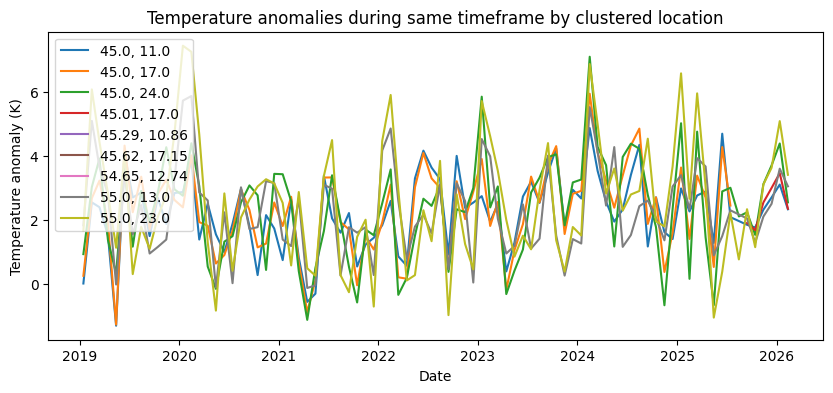

In [51]:
plot_temp_stats(merged, save = False)